In [26]:
# !pip install openai
# !pip install plotly
# !pip install mplfinance
# !pip install pandas_ta
# !pip install crontab
# !pip install edgartools
# !pip install alpaca-py
# !pip install tensorflow
# !pip install transformers
# !pip install torch
# !pip install yahoo_fin requests beautifulsoup4
# !pip install alpha_vantage
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install wordcloud
# !pip install praw
# !pip install tweepy
# !pip install streamlit
# !pip install dash
# !!pip install jupyter-dash

In [9]:
# Ask user for input
ticker = input("Enter an S&P 500 stock ticker (e.g., AAPL, MSFT, TSLA): ").upper().strip()

Enter an S&P 500 stock ticker (e.g., AAPL, MSFT, TSLA):  MCD


# REAL-TIME STOCK PRICE

**Start Zookeeper**

-> cd C:\kaf

-> .\bin\windows\zookeeper-server-start.bat .\config\zookeeper.properties 

**Start Kafka**

-> cd C:\kaf

-> .\bin\windows\kafka-server-start.bat .\config\server.properties

**Create Kafka Topic**

-> cd C:\kaf

-> .\bin\windows\kafka-topics.bat --create --topic stock_prices --bootstrap-server localhost:9092 --partitions 1 --replication-factor 1

**To verify the topic is created**

-> .\bin\windows\kafka-topics.bat --list --bootstrap-server localhost:9092



In [ ]:
!python plot_stock.py

# TECHNICAL ANALYSIS

In [10]:
import requests
import pandas as pd

# Set your EODHD API Key here
API_KEY = ' 67c1133a5815d0.62294566'  

def get_stock_data(symbol, exchange='US', interval='daily', output_size='full'):
    """
    Fetch stock data from EOD Historical Data API, including adjusted close prices.
    
    :param symbol: Stock ticker symbol (e.g., 'AAPL')
    :param exchange: Exchange code (e.g., 'US' for Nasdaq/NYSE)
    :param interval: 'daily', 'weekly', 'monthly', or 'intraday'
    :param output_size: 'full' for all available data, 'compact' for recent data only
    :return: DataFrame with stock data including adjusted close prices
    """

    # Define endpoint URL
    base_url = "https://eodhistoricaldata.com/api/eod/"
    url = f"{base_url}{symbol}.{exchange}"

    # Request parameters
    params = {
        'api_token': API_KEY,
        'period': interval,  # 'daily', 'weekly', 'monthly'
        'fmt': 'json',
        'order': 'desc' if output_size == 'full' else 'asc'  # Descending order (most recent first)
    }

    # Fetch data from API
    response = requests.get(url, params=params)

    # Handle HTTP errors
    if response.status_code != 200:
        print(f"Error: Unable to fetch data (status code {response.status_code})")
        return None

    data = response.json()

    # Handle API errors
    if not isinstance(data, list):
        print(f"API error: {data.get('message', 'Unknown error')}")
        return None

    # Convert JSON to DataFrame
    df = pd.DataFrame(data)

    # Ensure required columns exist
    required_cols = {'date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume'}
    if not required_cols.issubset(df.columns):
        print(f"Error: Missing columns {required_cols - set(df.columns)} in API response.")
        return None

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Rename columns for consistency
    df.rename(columns={'adjusted_close': 'adj_close'}, inplace=True)

    # Add ticker column
    df.insert(0, 'ticker', symbol)

    return df

stock_data = get_stock_data(ticker, interval='daily')

if stock_data is not None:
    stock_data = stock_data.sort_index()

    # Display first few rows
    pd.set_option('display.max_rows', 10)
    print(stock_data)
else:
    print("No data available.")

           ticker   open   high    low  close  adj_close   volume
date                                                             
2024-03-04    MCD 289.37 291.24 288.50 290.94     284.01  2832011
2024-03-05    MCD 291.56 293.51 288.92 292.54     285.58  2969609
2024-03-06    MCD 293.33 295.14 292.15 292.93     285.96  2347965
2024-03-07    MCD 294.20 294.92 291.03 291.11     284.18  2237730
2024-03-08    MCD 290.04 293.48 288.83 292.55     285.59  2482336
...           ...    ...    ...    ...    ...        ...      ...
2025-02-25    MCD 309.18 311.71 307.99 310.72     308.94  3891555
2025-02-26    MCD 311.70 314.55 303.68 304.27     302.52  4140908
2025-02-27    MCD 305.19 311.78 304.22 309.95     308.17  3350723
2025-02-28    MCD 307.61 308.52 303.88 308.33     306.56  4972872
2025-03-03    MCD 308.11 309.49 302.43 304.29     304.29  4371634

[250 rows x 7 columns]


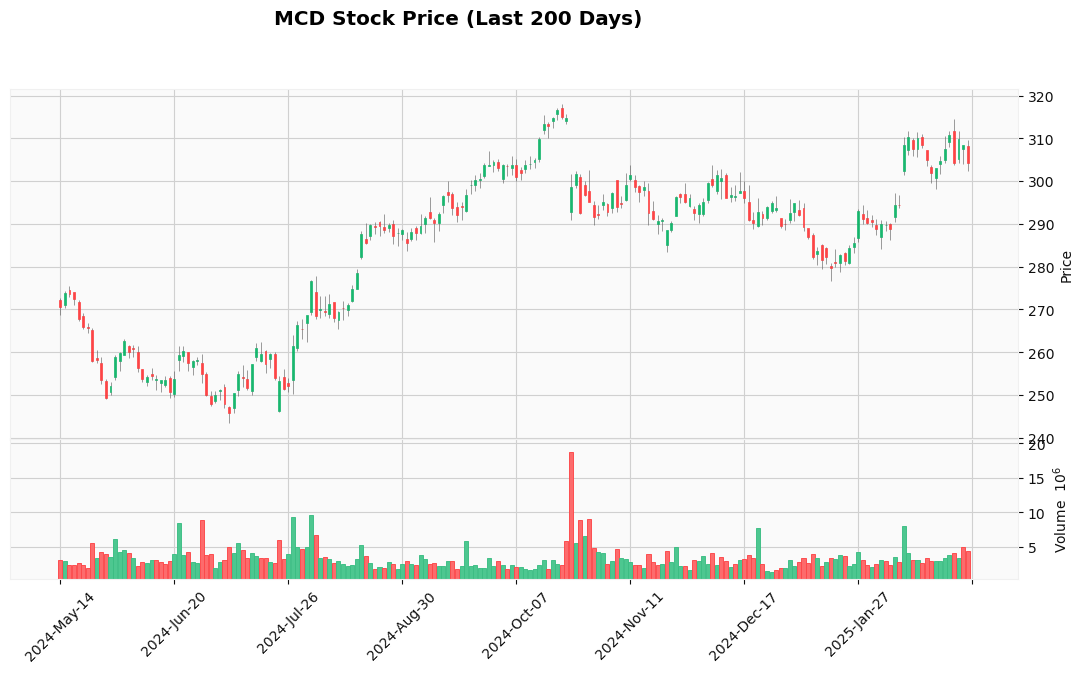

In [11]:
import mplfinance as mpf

if stock_data is not None and len(stock_data) >= 200:
    stock_data_plot = stock_data.tail(200)

    # Plot candlestick chart using mplfinance
    mpf.plot(
        stock_data_plot,
        type='candle',
        volume=True,
        style='yahoo',
        figsize=(14, 7),
        title=f"{ticker} Stock Price (Last 200 Days)",
    )
else:
    print("Not enough data available to plot.")

---------------------------------------------------------------------------------------------------------------------------------------------
# Technical Indicators Overview

### 1. Moving Averages (MA)
   - **MA50**: The 50-day simple moving average, often used to identify short-term trends.
   - **MA200**: The 200-day simple moving average, used for long-term trend analysis.

### 2. Relative Strength Index (RSI)
   A momentum oscillator that measures the speed and change of price movements. RSI values range from 0 to 100, typically indicating overbought conditions when above 70 and oversold conditions when below 30.

### 3. Moving Average Convergence Divergence (MACD)
   A trend-following momentum indicator that calculates the difference between two exponential moving averages (12-day and 26-day). The **MACD line** is then compared to a **signal line** (9-day EMA) to identify buy or sell signals.

### 4. Bollinger Bands
   A volatility indicator that consists of a **middle band** (SMA20), an **upper band** (2 standard deviations above the middle band), and a **lower band** (2 standard deviations below the middle band). It helps identify overbought or oversold conditions based on price volatility.

In [12]:
# Calculate technical indicators
def calculate_indicators(df):
    # 1. Moving Averages (MA)
    df['MA50'] = df['close'].rolling(window=50).mean()  # Short-term moving average (50-day)
    df['MA200'] = df['close'].rolling(window=200).mean()  # Long-term moving average (200-day)

    # 2. Relative Strength Index (RSI)
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 3. Moving Average Convergence Divergence (MACD)
    df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # 4. Bollinger Bands
    df['SMA20'] = df['close'].rolling(window=20).mean()
    df['20-day_std'] = df['close'].rolling(window=20).std()
    df['Upper_Band'] = df['SMA20'] + (df['20-day_std'] * 2)
    df['Lower_Band'] = df['SMA20'] - (df['20-day_std'] * 2)
    
    return df

----------------------------------------------------------------------------------------------------------------------------------------------
# Combining Indicators for a Robust Technical Strategy

### MACD + RSI:
- **Buy Signal**: If MACD crosses above the signal line and RSI rises above 30 (indicating the market was oversold), it’s a confirmation of bullish momentum.
- **Sell Signal**: If MACD crosses below the signal line and RSI falls below 70 (indicating the market was overbought), it’s a confirmation of bearish momentum.

### Bollinger Bands + RSI:
- **Buy Signal**: If the price hits the lower Bollinger Band and RSI is below 30 (oversold), it suggests a potential reversal to the upside.
- **Sell Signal**: If the price hits the upper Bollinger Band and RSI is above 70 (overbought), it suggests a potential reversal to the downside.

### Moving Averages + MACD:
- **Buy Signal**: If the price is above the moving average and the MACD crosses above its signal line, it suggests a confirmation of an uptrend.
- **Sell Signal**: If the price is below the moving average and the MACD crosses below its signal line, it suggests a confirmation of a downtrend.

In [13]:
import pandas as pd

def generate_signals(df):
    # Ensure MA_Cross is a boolean column (50-period MA > 200-period MA)
    df['MA_Cross'] = df['MA50'] > df['MA200']
    df['MA_Cross'] = df['MA_Cross'].astype(bool)  # Explicit conversion to boolean

    # Initialize Buy/Sell signal columns for each strategy
    df['Buy_MACD_RSI'], df['Sell_MACD_RSI'] = 0, 0
    df['Buy_BB_RSI'], df['Sell_BB_RSI'] = 0, 0
    df['Buy_MA_MACD'], df['Sell_MA_MACD'] = 0, 0

    # MACD + RSI Strategy
    df.loc[(df['MACD'] > df['Signal_Line']) & (df['MACD'].shift(1) <= df['Signal_Line']) & (df['RSI'] > 30), 'Buy_MACD_RSI'] = 1
    df.loc[(df['MACD'] < df['Signal_Line']) & (df['MACD'].shift(1) >= df['Signal_Line']) & (df['RSI'] < 70), 'Sell_MACD_RSI'] = -1

    # Bollinger Bands + RSI Strategy
    df.loc[(df['close'] < df['Lower_Band']) & (df['RSI'] < 30), 'Buy_BB_RSI'] = 1
    df.loc[(df['close'] > df['Upper_Band']) & (df['RSI'] > 70), 'Sell_BB_RSI'] = -1

    # Moving Averages + MACD Strategy
    df.loc[(df['close'] > df['MA50']) & (df['MACD'] > df['Signal_Line']) & (df['MACD'].shift(1) <= df['Signal_Line']), 'Buy_MA_MACD'] = 1
    df.loc[(df['close'] < df['MA50']) & (df['MACD'] < df['Signal_Line']) & (df['MACD'].shift(1) >= df['Signal_Line']), 'Sell_MA_MACD'] = -1

    return df

# Check if stock data exists before processing
if stock_data is not None:
    # Calculate indicators and generate signals
    stock_data = calculate_indicators(stock_data)  # Ensure this function exists
    stock_data = generate_signals(stock_data)

    # Display the last 10 rows with all strategy signals (excluding date)
    pd.set_option('display.float_format', '{:,.2f}'.format)

    print("\n" + "="*80)
    print("📊 Technical Signal Overview (Last 10 Rows)")
    print("="*80)

    print(stock_data[['ticker', 'close', 'MA50', 'MA200', 'MACD', 'Signal_Line', 'RSI', 
                      'Upper_Band', 'Lower_Band']]
          .tail(10)
          .to_string(index=False))  # Clean formatting
    
    # Display latest signals for each strategy
    latest_price = stock_data['close'].iloc[-1]

    latest_signals = {
        "MACD + RSI": ("BUY" if stock_data['Buy_MACD_RSI'].iloc[-1] == 1 else 
                       "SELL" if stock_data['Sell_MACD_RSI'].iloc[-1] == -1 else "HOLD"),
        "Bollinger Bands + RSI": ("BUY" if stock_data['Buy_BB_RSI'].iloc[-1] == 1 else 
                                  "SELL" if stock_data['Sell_BB_RSI'].iloc[-1] == -1 else "HOLD"),
        "Moving Averages + MACD": ("BUY" if stock_data['Buy_MA_MACD'].iloc[-1] == 1 else 
                                   "SELL" if stock_data['Sell_MA_MACD'].iloc[-1] == -1 else "HOLD")
    }

    print("\n" + "="*80)
    print("📈 Latest Technical Signals (Per Strategy)")
    print("="*80)
    print(f"💰 Last Price: ${latest_price:,.2f}\n")

    for strategy, signal in latest_signals.items():
        print(f"   {strategy}: {signal}")

    print("="*80)

else:
    print("\n❌ Failed to retrieve stock data. Check API key and request limits.")


📊 Technical Signal Overview (Last 10 Rows)
ticker  close   MA50  MA200  MACD  Signal_Line   RSI  Upper_Band  Lower_Band
   MCD 304.83 292.92 282.49  5.03         3.10 68.41      314.24      275.18
   MCD 301.94 293.06 282.62  4.70         3.42 65.16      314.59      276.76
   MCD 303.05 293.13 282.77  4.47         3.63 65.95      314.68      278.84
   MCD 304.81 293.25 282.94  4.39         3.78 70.11      315.05      280.51
   MCD 307.57 293.37 283.14  4.49         3.93 71.13      315.66      282.11
   MCD 310.72 293.57 283.35  4.77         4.09 73.63      317.10      282.43
   MCD 304.27 293.73 283.53  4.42         4.16 65.49      317.37      283.47
   MCD 309.95 294.00 283.74  4.55         4.24 65.59      318.14      284.68
   MCD 308.33 294.24 283.91  4.47         4.29 63.61      318.46      286.17
   MCD 304.29 294.37 284.07  4.04         4.24 45.02      317.92      288.26

📈 Latest Technical Signals (Per Strategy)
💰 Last Price: $304.29

   MACD + RSI: SELL
   Bollinger Bands + RS

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest(df, buy_col, sell_col, strategy_name, initial_capital=20000, position_size=250, stop_loss_pct=0.05):
    df = df.copy()  # Work with a copy to avoid modifying original data
    
    df['Position'] = 0
    df['Portfolio_Value'] = float(initial_capital)
    df['Entry_Price'] = np.nan
    df['Exit_Price'] = np.nan
    df['Profit_Loss'] = np.nan
    df['Stop_Loss'] = np.nan
    in_trade = False  # Track if we currently have an open position

    # Simulate the portfolio
    for i in range(1, len(df)):
        # Buy Signal (Only if not already in a trade)
        if df[buy_col].iloc[i] == 1 and not in_trade:
            df.iloc[i, df.columns.get_loc('Position')] = position_size
            df.iloc[i, df.columns.get_loc('Entry_Price')] = df['close'].iloc[i]
            df.iloc[i, df.columns.get_loc('Stop_Loss')] = df['close'].iloc[i] * (1 - stop_loss_pct)
            in_trade = True  # Mark as in trade
        
        # Stop-Loss Triggered (Exit position)
        elif in_trade and df['close'].iloc[i] <= df['Stop_Loss'].iloc[i-1]:  # Use i-1 for stop-loss calculation
            df.iloc[i, df.columns.get_loc('Position')] = 0  # Close position (no shorting)
            df.iloc[i, df.columns.get_loc('Exit_Price')] = df['close'].iloc[i]
            entry_price = df['Entry_Price'].iloc[i-1]  # Use i-1 to get the previous entry price
            exit_price = df['Exit_Price'].iloc[i]
            df.iloc[i, df.columns.get_loc('Profit_Loss')] = (exit_price - entry_price) * position_size
            in_trade = False  # No longer in a trade

        # Sell Signal (Only if in trade) - Change to -1 for Sell Signal
        elif df[sell_col].iloc[i] == -1 and in_trade:  # Sell Signal now is -1
            df.iloc[i, df.columns.get_loc('Position')] = 0  # Close position (no shorting)
            df.iloc[i, df.columns.get_loc('Exit_Price')] = df['close'].iloc[i]
            entry_price = df['Entry_Price'].iloc[i-1]  # Use i-1 to get the previous entry price
            exit_price = df['Exit_Price'].iloc[i]
            df.iloc[i, df.columns.get_loc('Profit_Loss')] = (exit_price - entry_price) * position_size
            in_trade = False  # No longer in a trade

        else:
            # Maintain current position if no trade is made
            df.iloc[i, df.columns.get_loc('Position')] = df.iloc[i-1, df.columns.get_loc('Position')]

        # Update portfolio value
        df.iloc[i, df.columns.get_loc('Portfolio_Value')] = float(df.iloc[i-1, df.columns.get_loc('Portfolio_Value')] + 
            df.iloc[i-1, df.columns.get_loc('Position')] * (df.iloc[i, df.columns.get_loc('close')] - df.iloc[i-1, df.columns.get_loc('close')]))

    return df

# Function to calculate important backtesting stats
def calculate_backtest_stats(df, strategy_name, initial_capital=20000, risk_free_rate=0.01):
    # Calculate Total Return
    total_return = (df['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
    
    # Calculate Daily Returns
    df['Daily_Returns'] = df['Portfolio_Value'].pct_change()

    # Calculate Annualized Return (Assuming 252 trading days per year)
    annualized_return = (df['Daily_Returns'].mean() + 1) ** 252 - 1
    
    # Calculate Volatility (Standard deviation of daily returns)
    volatility = df['Daily_Returns'].std() * np.sqrt(252)
    
    # Calculate Maximum Drawdown
    rolling_max = df['Portfolio_Value'].cummax()
    drawdown = (df['Portfolio_Value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Calculate Sharpe Ratio (Using risk-free rate)
    sharpe_ratio = (df['Daily_Returns'].mean() - risk_free_rate / 252) / df['Daily_Returns'].std() * np.sqrt(252)
    
    # Print detailed report
    print(f"\n Backtest Results Summary: {strategy_name}")
    print(f"{'-'*50}")
    print(f"Initial Capital: ${initial_capital:.2f}")
    print(f"Final Portfolio Value: ${df['Portfolio_Value'].iloc[-1]:.2f}")
    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Volatility (Annualized): {volatility:.2%}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    return df

# Run backtest independently for each strategy
strategies = {
    "MACD + RSI": ("Buy_MACD_RSI", "Sell_MACD_RSI"),
    "Bollinger Bands + RSI": ("Buy_BB_RSI", "Sell_BB_RSI"),
    "Moving Averages + MACD": ("Buy_MA_MACD", "Sell_MA_MACD"),
}

backtest_results = {}

for strategy_name, (buy_col, sell_col) in strategies.items():
    print(f"\nRunning backtest for: {strategy_name}...")
    backtest_results[strategy_name] = backtest(stock_data, buy_col, sell_col, strategy_name)
    backtest_results[strategy_name] = calculate_backtest_stats(backtest_results[strategy_name], strategy_name)

# Compare Total Returns
print("\n Strategy Performance Comparison:")
print("="*50)
for strategy_name in strategies.keys():
    final_value = backtest_results[strategy_name]['Portfolio_Value'].iloc[-1]
    total_return = (final_value - 20000) / 20000  # Assuming initial capital is 20,000
    print(f"{strategy_name}: Final Portfolio Value: ${final_value:,.2f} | Total Return: {total_return:.2%}")
print("="*50)

# Calculate Total Return on Stock (Buy & Hold)
total_return_stock = (stock_data['adj_close'].iloc[-1] - stock_data['adj_close'].iloc[0]) / stock_data['adj_close'].iloc[0]
print(f"\n📈 Total Return on Stock (Buy & Hold): {total_return_stock:.2%}")



Running backtest for: MACD + RSI...

 Backtest Results Summary: MACD + RSI
--------------------------------------------------
Initial Capital: $20000.00
Final Portfolio Value: $24132.50
Total Return: 20.66%
Annualized Return: 38.77%
Volatility (Annualized): 53.05%
Maximum Drawdown: -39.63%
Sharpe Ratio: 0.60

Running backtest for: Bollinger Bands + RSI...

 Backtest Results Summary: Bollinger Bands + RSI
--------------------------------------------------
Initial Capital: $20000.00
Final Portfolio Value: $22500.00
Total Return: 12.50%
Annualized Return: 21.86%
Volatility (Annualized): 40.10%
Maximum Drawdown: -34.44%
Sharpe Ratio: 0.47

Running backtest for: Moving Averages + MACD...

 Backtest Results Summary: Moving Averages + MACD
--------------------------------------------------
Initial Capital: $20000.00
Final Portfolio Value: $30602.50
Total Return: 53.01%
Annualized Return: 62.58%
Volatility (Annualized): 33.47%
Maximum Drawdown: -20.96%
Sharpe Ratio: 1.42

 Strategy Performanc

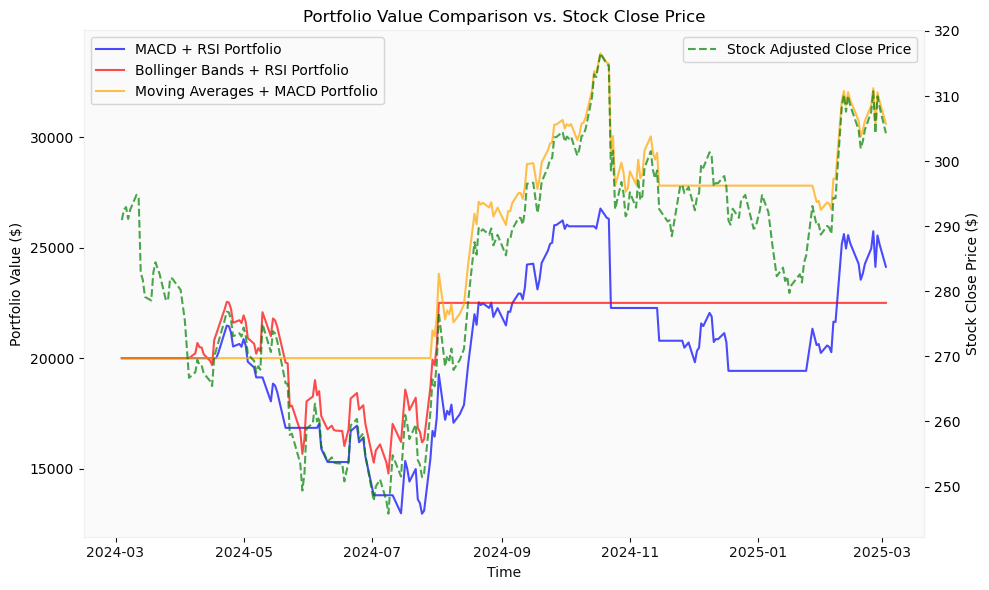

In [24]:
import matplotlib.pyplot as plt

def plot_all_strategies_vs_stock(backtest_results, ticker="Stock"):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot each strategy's Portfolio Value on the primary y-axis
    colors = {'MACD + RSI': 'b', 'Bollinger Bands + RSI': 'r', 'Moving Averages + MACD': 'orange'}
    
    for strategy_name, df in backtest_results.items():
        ax1.plot(df['Portfolio_Value'], color=colors[strategy_name], label=f'{strategy_name} Portfolio', alpha=0.7)

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Portfolio Value ($)', color='k')
    ax1.tick_params(axis='y', labelcolor='k')

    # Create a second y-axis for the stock's closing price
    ax2 = ax1.twinx()  
    ax2.plot(df['close'], color='g', linestyle='dashed', label=f'{ticker} Adjusted Close Price', alpha=0.7)
    ax2.set_ylabel(f'{ticker} Close Price ($)', color='k')
    ax2.tick_params(axis='y', labelcolor='k')

    # Title and labels
    plt.title(f'Portfolio Value Comparison vs. {ticker} Close Price')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show plot
    plt.tight_layout()
    ax1.grid(False)
    ax2.grid(False)
    plt.show()

# Call the function to plot all strategies
plot_all_strategies_vs_stock(backtest_results)

# FUNDAMENTAL ANALYSIS

In [35]:
import sqlite3
import pandas as pd
import time

# Retrieve the S&P 500 stock symbols and sector data
def get_sp500_symbols_and_sectors():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(url)
    sp500_df = tables[0]  # First table contains stock symbols and sectors
    return sp500_df[['Symbol', 'GICS Sector']].rename(columns={'Symbol': 'ticker', 'GICS Sector': 'sector'})

# Find all tickers in the same sector as the given ticker
def get_same_sector_tickers(ticker, sp500_df):
    sector = sp500_df.loc[sp500_df['ticker'] == ticker, 'sector'].values
    if len(sector) == 0:
        print(f"❌ {ticker} not found in S&P 500 list.")
        return []
    
    sector = sector[0]
    same_sector_tickers = sp500_df[sp500_df['sector'] == sector]['ticker'].tolist()
    print(f"  Sector: {sector}")
    print(f"📊 Found {len(same_sector_tickers)} tickers in the same sector as {ticker}")
    
    return same_sector_tickers

In [36]:
import requests
import time
import random

API_KEY = "rfxtGuPO4lt5yNQOIuS4r7P27L508Mvt"

def get_company_fundamentals(symbols):
    """
    Fetch fundamental financial data for multiple stock symbols using Financial Modeling Prep (FMP).
    If primary data is missing, try alternative endpoints.
    
    :param symbols: List of stock ticker symbols.
    :return: Dictionary with fundamental metrics for each stock.
    """
    fundamentals_data = {}

    for symbol in symbols:
        attempts = 0
        wait_time = 5  # Start with 5-second wait
        
        while attempts < 3:  # Retry up to 3 times if rate-limited
            try:
                # Primary API Endpoint (Company Profile)
                url_profile = f"https://financialmodelingprep.com/api/v3/profile/{symbol}?apikey={API_KEY}"
                response = requests.get(url_profile)
                if response.status_code == 200:
                    data = response.json()
                    if not data:
                        raise ValueError("No data returned from API")

                    company_data = data[0]  # FMP returns a list, extract first item

                    # Fetch Additional Key Metrics (for missing values)
                    url_metrics = f"https://financialmodelingprep.com/api/v3/key-metrics/{symbol}?apikey={API_KEY}"
                    response_metrics = requests.get(url_metrics)
                    metrics_data = response_metrics.json()[0] if response_metrics.status_code == 200 and response_metrics.json() else {}

                    # Fetch Ratios (for missing financial ratios)
                    url_ratios = f"https://financialmodelingprep.com/api/v3/ratios/{symbol}?apikey={API_KEY}"
                    response_ratios = requests.get(url_ratios)
                    ratios_data = response_ratios.json()[0] if response_ratios.status_code == 200 and response_ratios.json() else {}

                    # Extract relevant metrics (fill missing values with alternative sources)
                    metrics = {
                        'P/E Ratio': company_data.get('peRatio') or ratios_data.get('priceEarningsRatio', None),
                        'Market Cap': company_data.get('mktCap', None),
                        'Revenue': company_data.get('revenue') or metrics_data.get('revenuePerShare', None),
                        'Beta': company_data.get('beta', None),
                        'Return on Assets (ROA)': company_data.get('returnOnAssets') or ratios_data.get('returnOnAssets', None),
                        'Return on Equity (ROE)': company_data.get('returnOnEquity') or ratios_data.get('returnOnEquity', None),
                    }

                    fundamentals_data[symbol] = metrics
                    print(f"  Retrieved fundamentals for {symbol}")
                    break  # Exit retry loop if successful
                
                elif response.status_code == 429:  # Rate limit hit
                    print(f"⚠️ Rate limit hit for {symbol}.")
                    break
                
                else:
                    raise ValueError(f"Unexpected API response: {response.text}")

            except Exception as e:
                print(f"⚠️ Attempt {attempts + 1}: Failed to retrieve data for {symbol}. Error: {e}")
                attempts += 1
                time.sleep(wait_time)
                wait_time *= 2  # Exponential backoff
                
                if attempts == 3:  # Skip stock if it fails after 3 tries
                    print(f"❌ Skipping {symbol} after 3 failed attempts.")
                    fundamentals_data[symbol] = None

    return fundamentals_data

In [37]:
import sqlite3

def create_database():
    """
    Creates an SQLite database and a table for storing company fundamentals.
    If the table already exists, it deletes all existing data before creating it again.
    """
    conn = sqlite3.connect('company_fundamentals.db')
    cursor = conn.cursor()

    # Check if the table exists
    cursor.execute("""
        SELECT name FROM sqlite_master WHERE type='table' AND name='company_fundamentals'
    """)
    table_exists = cursor.fetchone()

    if table_exists:
        # If table exists, delete all data
        cursor.execute("DELETE FROM company_fundamentals")
        print("Existing data deleted from company_fundamentals.")

    # Create the table (if it doesn't exist)
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS company_fundamentals (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            symbol TEXT UNIQUE NOT NULL,
            pe_ratio REAL,
            market_cap INTEGER,
            revenue INTEGER,
            beta REAL,
            roa REAL,
            roe REAL,
            last_updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    """)

    conn.commit()
    conn.close()
    print("Database initialized: Table created and old data deleted.")

# Call this function once before running your script
create_database()

Existing data deleted from company_fundamentals.
Database initialized: Table created and old data deleted.


In [38]:
import sqlite3
import random

def insert_into_db(fundamentals):
    """
    Inserts fundamental financial data into the SQLite database.
    
    :param fundamentals: Dictionary containing fundamental metrics for multiple stocks.
    """
    conn = sqlite3.connect('company_fundamentals.db')
    cursor = conn.cursor()

    data_to_insert = []

    for symbol, metrics in fundamentals.items():
        if metrics is None:
            print(f"⚠️ Skipping {symbol}: No data retrieved from API.")
            continue  # Skip if no data was retrieved

        values = (
            symbol,
            metrics.get('P/E Ratio'),
            metrics.get('Market Cap'),
            metrics.get('Revenue'),
            metrics.get('Beta'),
            metrics.get('Return on Assets (ROA)'),
            metrics.get('Return on Equity (ROE)'),
        )

        data_to_insert.append(values)

    if data_to_insert:
        try:
            cursor.executemany("""
                INSERT OR REPLACE INTO company_fundamentals (
                    symbol, pe_ratio, market_cap, revenue, beta, roa, roe
                ) VALUES (?, ?, ?, ?, ?, ?, ?)
            """, data_to_insert)
        except sqlite3.IntegrityError as e:
            print(f"❌ Database error: {e}")

    conn.commit()
    conn.close()
    print("✅ Database updated successfully.")

# Get the list of S&P 500 stocks and their sectors
sp500_df = get_sp500_symbols_and_sectors()

# Get tickers from the same sector as the target stock
same_sector_tickers = get_same_sector_tickers(ticker, sp500_df)

# Ensure `ticker` is included in the list
if ticker in same_sector_tickers:
    same_sector_tickers.remove(ticker)  # Remove if it's already there to avoid duplication

# **Select up to 19 random tickers + the target ticker (ensuring a total of 20)**
selected_tickers = [ticker] + same_sector_tickers

# Fetch and insert data
fundamentals = get_company_fundamentals(selected_tickers)
insert_into_db(fundamentals)

  Sector: Information Technology
📊 Found 69 tickers in the same sector as MSFT
  Retrieved fundamentals for MSFT
  Retrieved fundamentals for ACN
  Retrieved fundamentals for ADBE
  Retrieved fundamentals for AMD
  Retrieved fundamentals for AKAM
  Retrieved fundamentals for APH
  Retrieved fundamentals for ADI
  Retrieved fundamentals for ANSS
  Retrieved fundamentals for AAPL
  Retrieved fundamentals for AMAT
  Retrieved fundamentals for ANET
  Retrieved fundamentals for ADSK
  Retrieved fundamentals for AVGO
  Retrieved fundamentals for CDNS
  Retrieved fundamentals for CDW
  Retrieved fundamentals for CSCO
  Retrieved fundamentals for CTSH
  Retrieved fundamentals for GLW
  Retrieved fundamentals for CRWD
  Retrieved fundamentals for DELL
  Retrieved fundamentals for ENPH
  Retrieved fundamentals for EPAM
  Retrieved fundamentals for FFIV
  Retrieved fundamentals for FICO
  Retrieved fundamentals for FSLR
  Retrieved fundamentals for FTNT
  Retrieved fundamentals for IT
  Retrieved

In [60]:
import sqlite3

# Reconnect to the database
conn = sqlite3.connect('company_fundamentals.db')
cursor = conn.cursor()

# Fetch all data from the company_fundamentals table
cursor.execute("SELECT * FROM company_fundamentals")
rows = cursor.fetchall()

# Print the column names
cursor.execute("PRAGMA table_info(company_fundamentals)")
columns = cursor.fetchall()
column_names = [column[1] for column in columns]  # Extract column names

# Display the column names and data
print("Columns:", column_names)
for row in rows:
    print(row)

# Close the connection
conn.close()

Columns: ['id', 'symbol', 'pe_ratio', 'market_cap', 'revenue', 'beta', 'roa', 'roe', 'last_updated']
(287, 'MSFT', 38.508221725515114, 2951141380400, 32.986408289597634, 0.895, 0.17208583985957596, 0.32828137978299815, '2025-03-03 14:32:18')
(288, 'ACN', 29.55271792763504, 217979780000, 103.36257691102418, 1.235, 0.1298852151124028, 0.25680928666575276, '2025-03-03 14:32:18')
(289, 'ADBE', 41.47854496402878, 190839465600, 48.1096196868009, 1.312, 0.18392325504465762, 0.3941864587025877, '2025-03-03 14:32:18')
(290, 'AMD', 123.58793418647164, 161813030400, 15.916666666666666, 1.736, 0.02370496634212579, 0.028505419677598665, '2025-03-03 14:32:18')
(291, 'AKAM', 28.679200979168897, 12127656240, 26.363136757556543, 0.676, 0.04869596582434683, 0.10350165024822906, '2025-03-03 14:32:18')
(292, 'APH', 34.49006188118812, 80657928000, 12.645539126100681, 1.236, 0.11305864684098096, 0.24754901960784315, '2025-03-03 14:32:18')
(293, 'ADI', 68.41396493429536, 114104238560, 19.000006046363517, 1.0

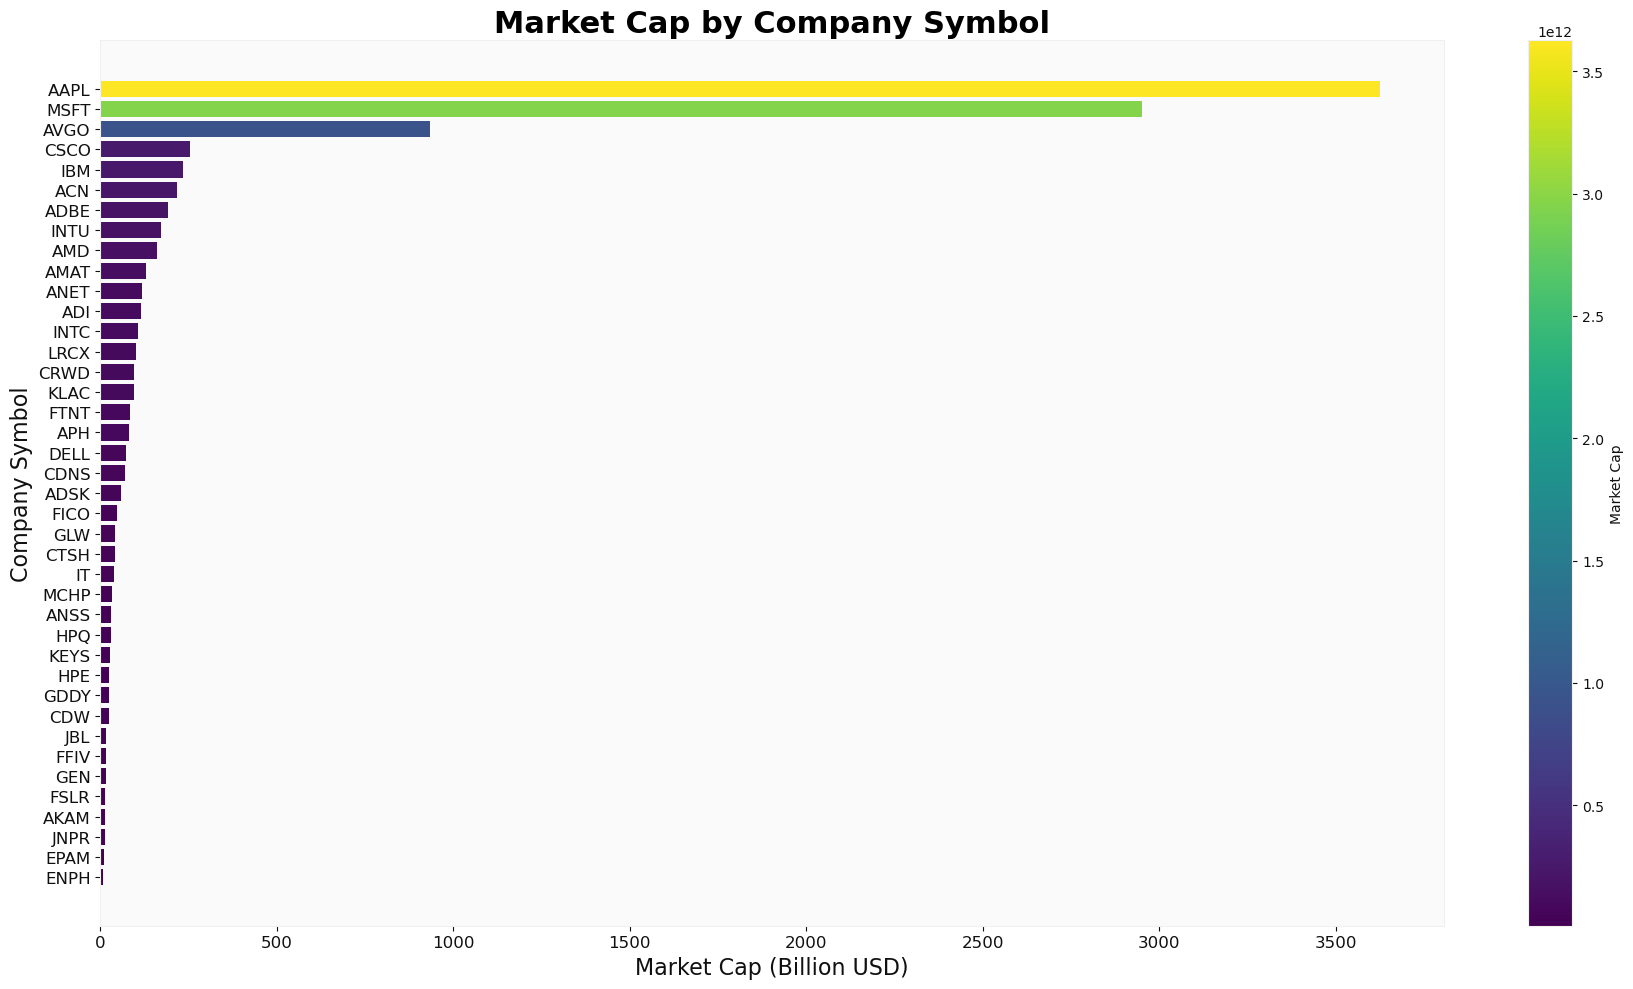

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Example: Load Data from SQLite Database (Modify as Needed)
import sqlite3

# Connect to SQLite and fetch the entire table
with sqlite3.connect("company_fundamentals.db") as conn:
    # Read the entire table into a DataFrame
    df = pd.read_sql("SELECT * FROM company_fundamentals", conn)
    
# Convert market cap to numeric (handling potential issues)
df['market_cap'] = pd.to_numeric(df['market_cap'], errors='coerce')

# Sort by market cap
df_sorted = df.sort_values('market_cap')

# Ensure we have data
if df_sorted.empty:
    print("  No market cap data available!")
else:
    plt.figure(figsize=(18, 10))

    # Normalize market cap for colormap
    norm = mcolors.Normalize(vmin=df_sorted['market_cap'].min(), vmax=df_sorted['market_cap'].max())
    cmap = plt.cm.viridis  # Change colormap if needed

    # Create bar chart
    bars = plt.barh(df_sorted['symbol'], df_sorted['market_cap'] / 1e9, color=cmap(norm(df_sorted['market_cap'])))

    plt.title('Market Cap by Company Symbol', fontsize=22, weight='bold')
    plt.xlabel('Market Cap (Billion USD)', fontsize=16)
    plt.ylabel('Company Symbol', fontsize=16)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), label='Market Cap')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [97]:
from sklearn.preprocessing import StandardScaler

# Select relevant numerical features for clustering (create a copy to avoid the warning)
features = df[['pe_ratio','market_cap', 'revenue', 'beta', 'roa', 'roe']].copy()

# Handle missing values by replacing them with the column mean
features.fillna(features.mean(), inplace=True)

# Scale the features (important for clustering)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [98]:
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message="KMeans is known to have a memory leak")

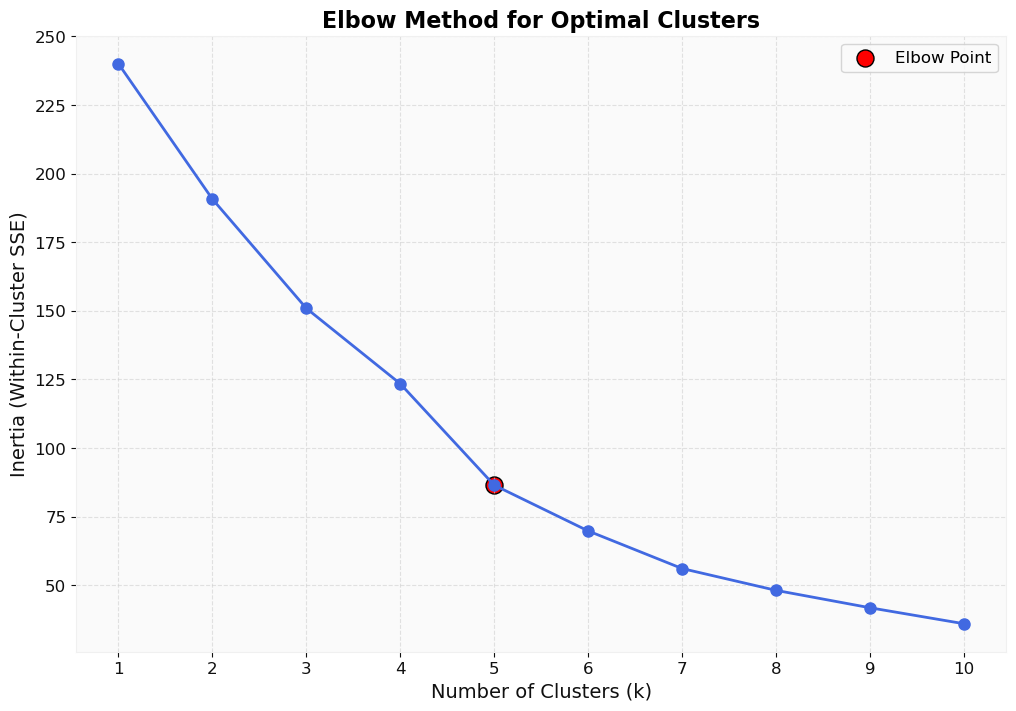

In [99]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define range of clusters to test
k_range = range(1, 11)

# Compute inertia for each k
inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Create figure
plt.figure(figsize=(12, 8))

# Plot inertia values
plt.plot(k_range, inertia, marker='o', linestyle='-', color='royalblue', markersize=8, linewidth=2)

# Format the plot
plt.title('Elbow Method for Optimal Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia (Within-Cluster SSE)', fontsize=14)
plt.xticks(k_range, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate the elbow point (if visible)
elbow_k = 5  # Adjust this based on the curve's visual breakpoint
plt.scatter(elbow_k, inertia[elbow_k - 1], s=150, color='red', label='Elbow Point', edgecolors='black')
plt.legend(fontsize=12)

# Show the plot
plt.show()

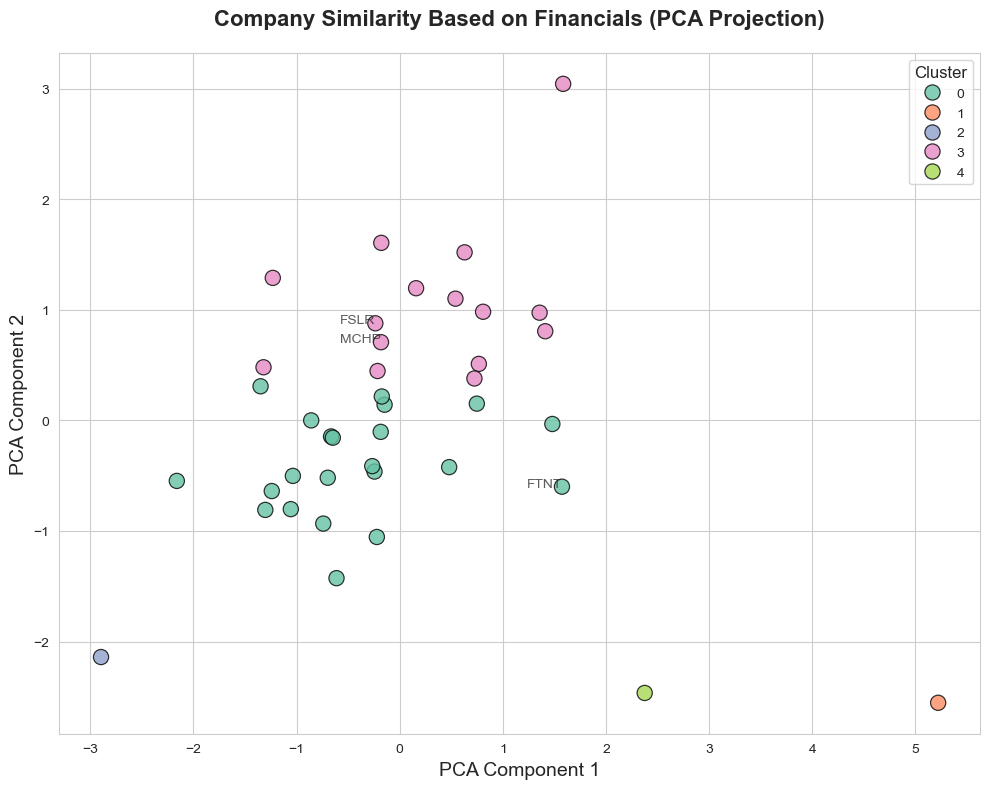

In [100]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

# Choose the number of clusters (let's say 3 as an example)
kmeans = KMeans(n_clusters=5)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Perform PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(scaled_features)

df['pca_x'] = df_pca[:, 0]
df['pca_y'] = df_pca[:, 1]

# Set up the figure
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Define color palette
num_clusters = df['cluster'].nunique()
palette = sns.color_palette("Set2", num_clusters)  # Soft colors for clarity

# Create scatter plot
scatter = sns.scatterplot(
    x='pca_x', 
    y='pca_y', 
    hue='cluster', 
    palette=palette, 
    data=df, 
    s=120,  # Point size
    alpha=0.8,  # Transparency for better visibility
    edgecolor='black'  # Add edge to points for better contrast
)

# Add company labels to a subset of points
for i, row in df.iterrows():
    if np.random.rand() < 0.1:  # Label a fraction of points to reduce clutter
        plt.text(row['pca_x'], row['pca_y'], row['symbol'], fontsize=10, ha='right', alpha=0.75)

# Title and labels
plt.title("Company Similarity Based on Financials (PCA Projection)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)
plt.legend(title="Cluster", title_fontsize=12, fontsize=10)

# Improve layout
plt.tight_layout()
plt.show()

In [101]:
# Get the cluster label of the given ticker
ticker_cluster = df[df['symbol'] == ticker]['cluster'].values[0]

# Find all companies in the same cluster but exclude the 'ticker' company
companies_in_cluster = df[df['cluster'] == ticker_cluster]['symbol'].tolist()
companies_in_cluster = [company for company in companies_in_cluster if company != ticker]

# Display the list of companies in the same cluster as 'ticker', excluding 'ticker'
print(f"Companies in the same cluster as {ticker}:")
print(", ".join(companies_in_cluster))

Companies in the same cluster as AAPL:



In [107]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import time

API_KEY = "API_KEY"
ts = TimeSeries(key=API_KEY, output_format="pandas")

# Fetch data for all stocks
all_data = {}

for symbol in companies_in_cluster + [ticker]:  # Convert ticker to a list
    try:
        data, meta_data = ts.get_daily(symbol=ticker, outputsize="compact")
        all_data[ticker] = data["4. close"].copy()  # Extract closing prices
        print(f"Fetched data for {ticker}")
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Combine into a DataFrame
df = pd.DataFrame(all_data).copy()  
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)  

Fetched data for MSFT


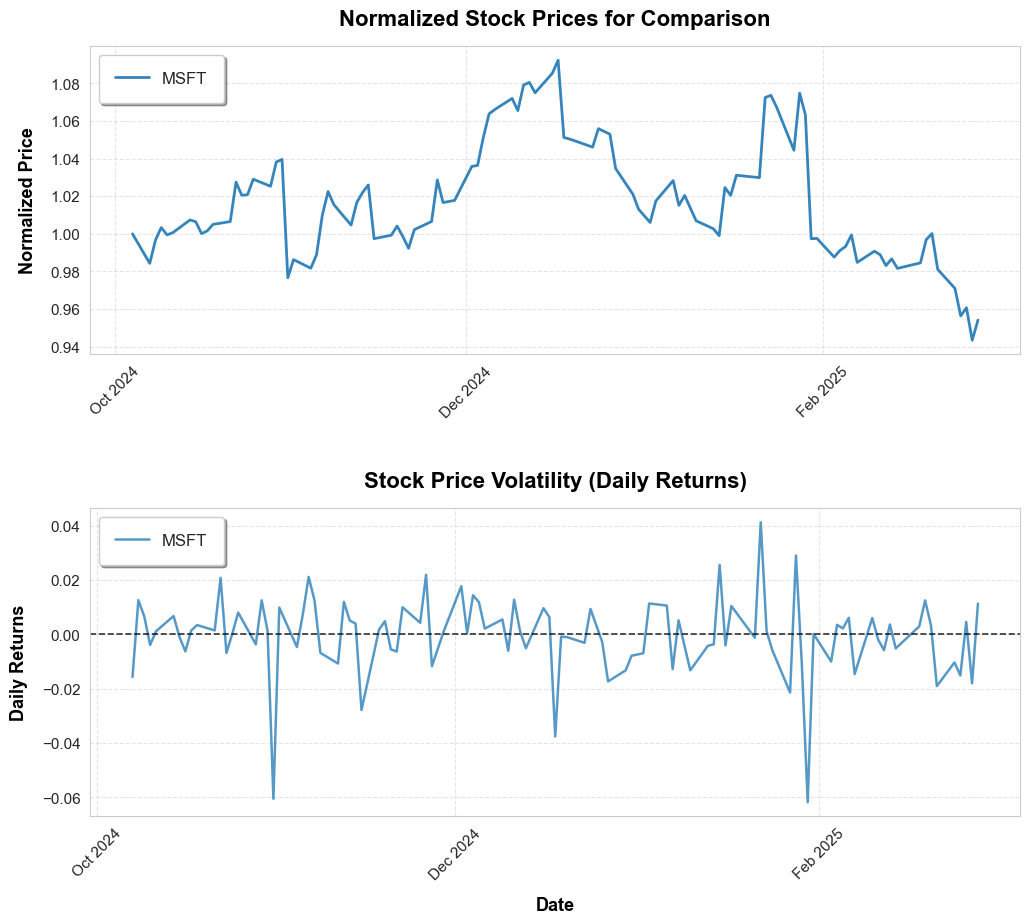

In [108]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure copies before modifying
df_norm = df.copy() / df.iloc[0]  # Normalize prices (first price = 1)
df_returns = df.copy().pct_change().dropna()  # Compute daily percentage changes

# Create figure and axes with improved layout
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,10), dpi=100, gridspec_kw={'hspace': 0.5})

# --- Plot Normalized Price Chart ---
axes[0].set_title("Normalized Stock Prices for Comparison", fontsize=16, fontweight='bold', color='black', pad=15)
for stock in df_norm.columns:
    axes[0].plot(df_norm.index, df_norm[stock], label=stock, linewidth=2, alpha=0.9)
axes[0].set_ylabel("Normalized Price", fontsize=13, fontweight='bold', color='black', labelpad=10)
axes[0].legend(fontsize=12, loc="upper left", frameon=True, shadow=True, fancybox=True, borderpad=1)
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
axes[0].tick_params(axis='x', rotation=45, labelsize=11)
axes[0].tick_params(axis='y', labelsize=11)

# --- Plot Volatility Chart (Daily Returns) ---
axes[1].set_title("Stock Price Volatility (Daily Returns)", fontsize=16, fontweight='bold', color='black', pad=15)
for stock in df_returns.columns:
    axes[1].plot(df_returns.index, df_returns[stock], label=stock, linewidth=1.8, alpha=0.75)
axes[1].set_xlabel("Date", fontsize=13, fontweight='bold', color='black', labelpad=10)
axes[1].set_ylabel("Daily Returns", fontsize=13, fontweight='bold', color='black', labelpad=10)
axes[1].legend(fontsize=12, loc="upper left", frameon=True, shadow=True, fancybox=True, borderpad=1)
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].axhline(0, color='black', linewidth=1.2, linestyle="--", alpha=0.8)  # Zero return reference line
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
axes[1].tick_params(axis='x', rotation=45, labelsize=11)
axes[1].tick_params(axis='y', labelsize=11)

plt.show()

---
# MACROECONOMIC ANALYSIS

In [109]:
import pandas_datareader.data as web
import sqlite3
import datetime
import pandas as pd

# Define the date range
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# Example indicators
indicators = [
    'CPIAUCSL',  # Consumer Price Index (CPI)
    'PPIACO',    # Producer Price Index (PPI)
    'UNRATE',    # Unemployment Rate
    'PAYEMS',    # Nonfarm Employment
    'FEDFUNDS',  # Federal Funds Rate
    'GS10',      # 10-Year Treasury Yield
    'UMCSENT',   # Consumer Confidence Index
    'GDPC1',     # Real GDP
    'RRSFS',     # Retail Sales
    'HOUST',     # Housing Starts
    'M1SL',      # M1 Money Supply
    'M2SL'       # M2 Money Supply
]

# Fetch the data from FRED
economic_data = {}
for indicator in indicators:
    try:
        df = web.DataReader(indicator, 'fred', start, end)
        if not df.empty:
            df.columns = ['value']
            df.index.name = 'date'
            economic_data[indicator] = df
        else:
            print(f"⚠ No data available for {indicator}. Skipping...")
    except Exception as e:
        print(f"❌ Could not retrieve {indicator}: {e}")

# Connect to SQLite database
conn = sqlite3.connect('economic_data.db')

# Store data in SQLite
for indicator, df in economic_data.items():
    if not df.empty:
        # Store data efficiently using pandas' to_sql
        df.to_sql(indicator, conn, if_exists='replace', index=True)

# Close the connection
conn.close()

print("\n All available economic data has been saved to SQLite successfully.")


 All available economic data has been saved to SQLite successfully.


In [110]:
import pandas as pd
import sqlite3

# List of economic indicators
indicators = [
    'CPIAUCSL', 'PPIACO', 'UNRATE', 'PAYEMS', 'FEDFUNDS', 'GS10',
    'UMCSENT', 'GDPC1', 'RRSFS', 'HOUST', 'M1SL', 'M2SL'
]

# Connect to SQLite database
conn = sqlite3.connect('economic_data.db')

# List to store DataFrames
dfs = []

# Loop through each table and fetch ALL available data
for indicator in indicators:
    try:
        query = f"SELECT date, value FROM {indicator} ORDER BY date ASC"
        df = pd.read_sql(query, conn)

        if df.empty:
            print(f"⚠️ No data found for {indicator}. Skipping...")
            continue

        # Convert date column to datetime format
        df['date'] = pd.to_datetime(df['date'])
        df.rename(columns={'value': indicator}, inplace=True)

        # Set date as index
        df.set_index('date', inplace=True)

        # Add DataFrame to the list
        dfs.append(df)

    except Exception as e:
        print(f"❌ Error fetching {indicator}: {e}")

# Close the database connection
conn.close()

# Combine all DataFrames
if dfs:
    combined_df = pd.concat(dfs, axis=1).sort_index(ascending=True)
    
    # Handle missing values
    combined_df = combined_df.ffill().bfill()

    # Display the result
    print("\n📊 Full Historical Economic Data (Preview of Latest 10 Rows):")
    print(combined_df.tail(10).to_string())  # Show last 10 rows
else:
    print("❌ No valid data retrieved.")


📊 Full Historical Economic Data (Preview of Latest 10 Rows):
            CPIAUCSL  PPIACO  UNRATE  PAYEMS  FEDFUNDS  GS10  UMCSENT     GDPC1   RRSFS  HOUST      M1SL      M2SL
date                                                                                                              
2024-04-01    313.02  256.98    3.90  157635      5.33  4.54    77.20 23,223.91  224487   1377 17,975.80 20,931.60
2024-05-01    313.14  255.31    4.00  157828      5.33  4.48    69.10 23,223.91  224918   1315 18,011.90 21,013.00
2024-06-01    313.13  255.91    4.10  157915      5.33  4.31    68.20 23,223.91  224299   1329 18,046.80 21,079.20
2024-07-01    313.57  257.32    4.20  158003      5.33  4.25    66.40 23,400.29  226699   1262 18,029.20 21,093.60
2024-08-01    314.13  255.46    4.20  158074      5.33  3.87    67.90 23,400.29  226032   1379 18,086.80 21,182.50
2024-09-01    314.85  252.68    4.10  158314      5.13  3.72    70.10 23,400.29  227532   1355 18,138.90 21,252.40
2024-10-01    315.

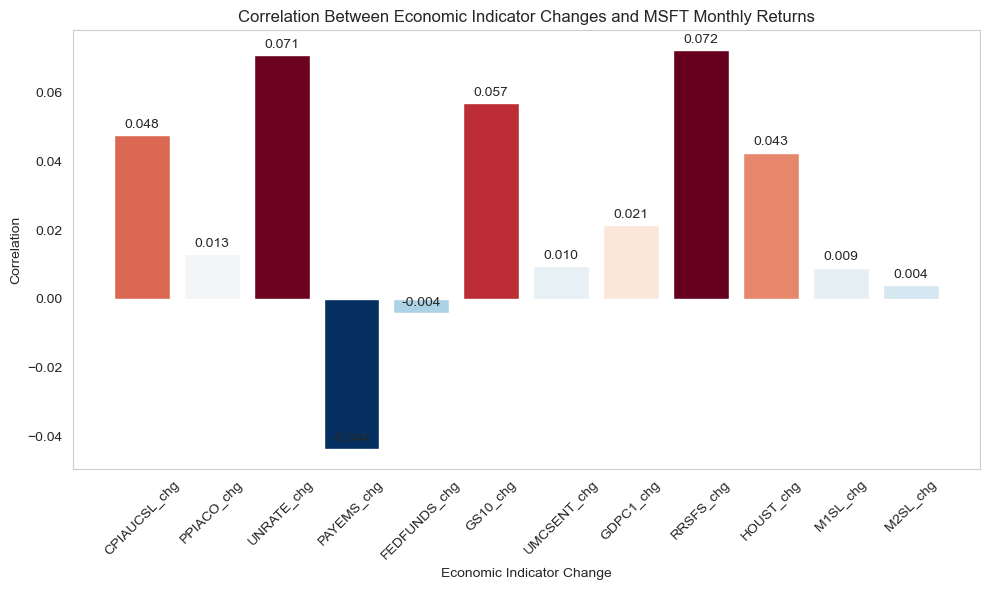

In [111]:
import pandas as pd
import sqlite3
import datetime
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# 🔹 Replace with your Alpha Vantage API Key
ALPHA_VANTAGE_API_KEY = "shawncavasos"

# --- Fetch Economic Data from SQLite ---
conn = sqlite3.connect('economic_data.db')
available_tables = [row[0] for row in conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()]

indicators = ['CPIAUCSL', 'PPIACO', 'UNRATE', 'PAYEMS', 'FEDFUNDS', 
              'GS10', 'UMCSENT', 'GDPC1', 'RRSFS', 'HOUST', 'M1SL', 'M2SL']
dfs = []

for indicator in indicators:
    if indicator in available_tables:
        df = pd.read_sql(f"SELECT date, value FROM {indicator} ORDER BY date ASC", conn)
        df['date'] = pd.to_datetime(df['date'])
        df['date'] = df['date'].dt.to_period('M').dt.to_timestamp()  # Convert to start-of-month timestamp
        df.rename(columns={'value': indicator}, inplace=True)
        df.set_index('date', inplace=True)
        dfs.append(df)
    else:
        print(f"⚠️ Warning: Table {indicator} not found in database.")

conn.close()

if dfs:
    economic_df = pd.concat(dfs, axis=1).ffill().bfill()  # Fill missing values
else:
    print("❌ No economic data tables found in the database.")
    exit()

# --- Fetch Historical Stock Data ---
start_date = economic_df.index.min().strftime('%Y-%m-%d')
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

try:
    ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
    stock_data, meta_data = ts.get_daily(symbol=ticker, outputsize="full")  # Fetch stock data

    # Rename and format date
    stock_data.rename(columns={"4. close": ticker}, inplace=True)
    stock_data.index = pd.to_datetime(stock_data.index)

    # Convert daily stock data to monthly (using the last day of each month)
    stock_monthly = stock_data.resample('ME').last()
    stock_monthly.index = stock_monthly.index.to_period('M').to_timestamp()  # Convert to monthly timestamp
except Exception as e:
    print(f"❌ Error fetching {ticker} data from Alpha Vantage: {e}")
    exit()

# --- Merge Economic Data with Stock Data ---
merged_df = economic_df.join(stock_monthly[ticker], how='inner')

# Calculate Stock Monthly Returns (percentage change)
merged_df[f'{ticker}_Returns'] = merged_df[ticker].pct_change()
merged_df = merged_df.dropna(subset=[f'{ticker}_Returns'])

# Compute Monthly Percentage Changes (i.e. Changes) for Each Economic Indicator
for indicator in indicators:
    merged_df[indicator + '_chg'] = merged_df[indicator].pct_change()

# Drop Rows with NA Values for Change Columns (for Correlation Calculations)
merged_df = merged_df.dropna(subset=[ind + '_chg' for ind in indicators])

# Compute Correlations Between Stock Returns and Changes in Each Economic Indicator
change_columns = [ind + '_chg' for ind in indicators]
correlation_with_returns = merged_df.corr()[f'{ticker}_Returns']
plot_corr = correlation_with_returns.loc[change_columns]

# Convert to DataFrame for Plotting
plot_corr_df = plot_corr.reset_index()
plot_corr_df.columns = ['Indicator_Change', 'Correlation']

# --- Plot a Color-Coded Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 6))

# Normalize and get colors for each bar using RdBu_r colormap
norm = colors.Normalize(vmin=plot_corr_df['Correlation'].min(), vmax=plot_corr_df['Correlation'].max())
cmap = plt.get_cmap('RdBu_r')
bar_colors = [cmap(norm(val)) for val in plot_corr_df['Correlation']]

bars = ax.bar(plot_corr_df['Indicator_Change'], plot_corr_df['Correlation'], color=bar_colors)

ax.set_title(f'Correlation Between Economic Indicator Changes and {ticker} Monthly Returns')
ax.set_xlabel('Economic Indicator Change')
ax.set_ylabel('Correlation')

# Annotate Each Bar with Its Correlation Value
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Vertical Offset in Points
                textcoords="offset points",
                ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
ax.grid(False)
plt.show()

In [112]:
import sqlite3
import requests
from datetime import date, timedelta

# Hardcoded API Key
API_KEY = "da4034cbcb214777a510dd89b5b9bb69"

# Define the date range (past 14 days)
today = date.today()
past_week = today - timedelta(days=14)

# News API URL and parameters
url = "https://newsapi.org/v2/everything"
params = {
    "q": "macroeconomics",
    "from": past_week.strftime("%Y-%m-%d"),
    "to": today.strftime("%Y-%m-%d"),
    "sortBy": "popularity",
    "language": "en",
    "apiKey": API_KEY
}

# Connect to SQLite database
conn = sqlite3.connect("news_data.db")
cursor = conn.cursor()

# Send request to News API
response = requests.get(url, params=params)
data = response.json()

# Check if the request was successful
if data.get("status") == "ok":
    articles = data.get("articles", [])[:5]  # Take only the top 10

    for article in articles:
        title = article["title"].strip() if article["title"] else None
        description = article["description"].strip() if article["description"] else None
        url = article["url"].strip() if article["url"] else None
        published_at = article["publishedAt"].strip() if article["publishedAt"] else None

        # ✅ Check if the article already exists before inserting
        cursor.execute("SELECT COUNT(*) FROM news WHERE url = ?", (url,))
        exists = cursor.fetchone()[0]

        if exists == 0:  # Only insert if the article does not exist
            cursor.execute("""
                INSERT INTO news (title, description, url, published_at)
                VALUES (?, ?, ?, ?)
            """, (title, description, url, published_at))
            

    # Commit and close database
    conn.commit()
    conn.close()

    # ✅ Display the top 5 news titles with article links
    print(f"\n**Top 10 Macroeconomic Headlines (Past 2 Weeks: {past_week} to {today})**\n")
    for idx, article in enumerate(articles, start=1):
        print(f"    {idx}. {article['title']} (Source: {article['source']['name']})")
        print(f"    🔗 {article['url']}\n")

else:
    print("❌ Error:", data.get("message"))


**Top 10 Macroeconomic Headlines (Past 2 Weeks: 2025-02-17 to 2025-03-03)**

    1. Jobless claims spike... (Source: CNN)
    🔗 https://www.cnn.com/2025/02/27/economy/us-jobless-claims-layoffs/index.html

    2. Rethinking Unemployment Insurance: New Evidence on Hidden Costs (Source: Nakedcapitalism.com)
    🔗 https://www.nakedcapitalism.com/2025/02/rethinking-unemployment-insurance-new-evidence-on-hidden-costs.html

    3. Introduction to Empirical Macroeconomics with R workshop (Source: R-bloggers.com)
    🔗 https://www.r-bloggers.com/2025/02/introduction-to-empirical-macroeconomics-with-r-workshop/

    4. Morena and Claudia Sheinbaum Have Kept Up Mexico’s Move to the Left (Source: Thenation.com)
    🔗 https://www.thenation.com/article/world/mexico-amlo-sheinbaum-morena/

    5. Unemployment claims rise to 242,000, the highest in 3 months (Source: CBS News)
    🔗 https://www.cbsnews.com/news/unemployment-benefits-claims-rise-2025/



##  Macro & Market News: Key Headlines for Investors

In [113]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("news_data.db")
df = pd.read_sql("SELECT title, url, published_at FROM news", conn)

conn.close()

df["url"] = df["url"].apply(lambda x: f'<a href="{x}" target="_blank">🔗 Read More</a>')
df.columns = ["📰 Headline", "🔗 Article Link", "📅 Published Date"]


import IPython.core.display as display
display.HTML(df.to_html(escape=False, index=False))

📰 Headline,🔗 Article Link,📅 Published Date
"Crypto, Interest Rates And AI: How To Navigate 2025 Macro Economics",🔗 Read More,2025-02-13T21:25:52Z
This Community College Has Ivy League Professors And Is Backed By Sam Altman,🔗 Read More,2025-02-12T11:30:00Z
A Trade War Interpreted in a Blanchard IS-LM Model,🔗 Read More,2025-02-16T03:34:58Z
Morena and Claudia Sheinbaum Have Kept Up Mexico’s Move to the Left,🔗 Read More,2025-02-17T10:00:02Z
Sundance Online Leaks Shouldn’t Scare Filmmakers: It’s Part of the Appeal,🔗 Read More,2025-02-11T17:30:00Z
Why Europe's southern periphery props up eurozone growth,🔗 Read More,2025-02-13T12:03:00Z
EXCLUSIVE: What VC Firms Expect From Crypto Projects This Year With Foresight Ventures,🔗 Read More,2025-02-18T12:10:01Z
U.S. retail sales plunge along with temperatures in January after a bustling holiday season,🔗 Read More,2025-02-14T21:10:50Z
Is Germany's industrial economic model in danger?,🔗 Read More,2025-02-19T17:45:00Z
11 Signs That A Recession In The U.S. May Have Already Started,🔗 Read More,2025-02-10T21:21:36Z


## Keyword Search: Count Macro Indicator Mentions in News Titles

In [114]:
from collections import defaultdict
from IPython.display import display

In [115]:
indicator_keywords = {
    "CPIAUCSL": ["inflation", "consumer prices", "CPI", "cost of living", "price index"],
    "PPIACO": ["producer price index", "PPI", "wholesale prices", "factory prices"],
    "UNRATE": ["unemployment", "jobless claims", "labor market", "job cuts", "hiring"],
    "PAYEMS": ["payrolls", "employment growth", "nonfarm payrolls", "jobs report", "job creation"],
    "FEDFUNDS": ["interest rates", "Federal Reserve", "Fed policy", "rate hikes", "rate cuts"],
    "GS10": ["treasury yield", "10-year yield", "bond market", "fixed income"],
    "UMCSENT": ["consumer confidence", "consumer sentiment", "economic optimism"],
    "GDPC1": ["GDP", "economic growth", "recession", "expansion", "contraction"],
    "RRSFS": ["retail sales", "consumer spending", "shopping trends", "e-commerce"],
    "HOUST": ["housing market", "home sales", "housing starts", "mortgage rates"],
    "M1SL": ["money supply", "liquidity", "monetary base", "cash supply"],
    "M2SL": ["money supply", "credit growth", "bank deposits", "money aggregates"]
}


conn = sqlite3.connect("news_data.db")
df = pd.read_sql("SELECT title FROM news", conn)


conn.close()


def count_macro_mentions(df, indicator_keywords):
    keyword_counts = defaultdict(int)

    for _, row in df.iterrows():
        title = row["title"].lower()
        for indicator, keywords in indicator_keywords.items():
            for keyword in keywords:
                if keyword.lower() in title:
                    keyword_counts[indicator] += 1

    return pd.DataFrame(keyword_counts.items(), columns=["Indicator", "Mentions"]).sort_values(by="Mentions", ascending=False)


macro_mentions_df = count_macro_mentions(df, indicator_keywords)

if not macro_mentions_df.empty:
    display(macro_mentions_df)
else:
    print("No macro-related mentions found in news titles.")

,Indicator,Mentions
3,UNRATE,3
5,RRSFS,2
0,GDPC1,1
1,UMCSENT,1
2,FEDFUNDS,1
4,HOUST,1


# SOCIAL MEDIA TREND ANALYSIS

In [116]:
import praw

# 🔹 Reddit API credentials
REDDIT_CLIENT_ID = "iGbUVH-wZqqHRysT7wIEfg"  
REDDIT_CLIENT_SECRET = "iHq4HqhFESF3WiyLV6mRvCdNdKR_6Q" 
REDDIT_USER_AGENT = "RefrigeratorFew6940:WSB-Tracker:v1.0"

# 🔹 Connect to Reddit API
reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT
)

try:
    print(f"✅ Connected as: {reddit.user.me()}")
except Exception as e:
    print(f"❌ Authentication failed: {e}")

✅ Connected as: None


In [117]:
import praw
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# 🔹 Reddit API credentials
REDDIT_CLIENT_ID = "iGbUVH-wZqqHRysT7wIEfg"
REDDIT_CLIENT_SECRET = "iHq4HqhFESF3WiyLV6mRvCdNdKR_6Q"
REDDIT_USER_AGENT = "RefrigeratorFew6940:WSB-Tracker:v1.0"

# 🔹 Connect to Reddit API
reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT
)

# 🔹 Function to fetch mentions with timestamps, upvotes, downvotes, and discussion link
def get_recent_ticker_mentions(ticker):
    subreddit = reddit.subreddit("wallstreetbets")
    mentions = []
    
    # Use proper UTC timezone
    six_months_ago = datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=180)
    
    for post in subreddit.search(f"${ticker}", limit=200):  # Fetch last 200 mentions
        post_time = datetime.datetime.fromtimestamp(post.created_utc, datetime.timezone.utc)

        # Only keep posts from the last 6 months
        if post_time >= six_months_ago:
            upvotes = post.score
            upvote_ratio = post.upvote_ratio
            downvotes = int(upvotes * (1 - upvote_ratio))  # Estimate downvotes
            # Build the full discussion link from the post's permalink
            link = "https://www.reddit.com" + post.permalink
            mentions.append((ticker, post.title, upvotes, downvotes, post_time, link))

    return mentions

recent_mentions = get_recent_ticker_mentions(ticker)

In [118]:
import pandas as pd
from IPython.display import display, HTML

# 🔹 Display 10 most recent mentions in a clean, clickable table
if recent_mentions:
    # Create DataFrame
    df_mentions = pd.DataFrame(
        recent_mentions,
        columns=['Ticker', 'Title', 'Upvotes', 'Downvotes', 'Date', 'Link']
    )

    # Convert Date column to datetime format
    df_mentions['Date'] = pd.to_datetime(df_mentions['Date'], errors='coerce')

    # Sort by Date in descending order
    df_mentions.sort_values('Date', ascending=False, inplace=True)

    # Select the 10 most recent entries
    df_display = df_mentions.head(10).copy()

    # Format the Date column
    df_display['Date'] = df_display['Date'].dt.strftime('%Y-%m-%d')

    # Convert links into proper HTML clickable hyperlinks
    df_display['Link'] = df_display['Link'].apply(lambda url: f'<a href="{url}" target="_blank">🔗 Discussion</a>')

    # Display table with left-aligned title column (works only in Jupyter Notebook)
    style = """
    <style>
        table { width: 100%; border-collapse: collapse; }
        th { text-align: center; padding: 8px; background-color: #f2f2f2; }
        td { padding: 8px; text-align: left; }  /* Ensure left-aligned text */
        td:nth-child(3), td:nth-child(4) { text-align: center; }  /* Center align Upvotes & Downvotes */
        td:nth-child(5) { text-align: center; }  /* Center align Date */
        td:nth-child(6) { text-align: center; }  /* Center align Link */
    </style>
    """

    display(HTML(style + df_display.to_html(escape=False, index=False)))
else:
    print("❌ No recent mentions found.")

Ticker,Title,Upvotes,Downvotes,Date,Link
MSFT,to everyone who jokingly told me to double it…,4595,183,2025-02-27,🔗 Discussion
MSFT,NVDA earnings. What's the risk? 50/50,15755,472,2025-02-24,🔗 Discussion
MSFT,"In the past 30 years, MSFT was under water for 16 years",1301,78,2025-02-24,🔗 Discussion
MSFT,Dropbox $DBX is about to Drop (50k 0dte puts),539,21,2025-02-20,🔗 Discussion
MSFT,MSFT YOLO (This is only the beginning),62,4,2025-02-19,🔗 Discussion
MSFT,AMD and MSFT?!,127,3,2025-02-15,🔗 Discussion
MSFT,MSFT you need to wake up,91,7,2025-02-14,🔗 Discussion
MSFT,MSFT,92,3,2025-02-13,🔗 Discussion
MSFT,"France to Announce €109 Billion in AI Investments, Macron Says",1989,59,2025-02-09,🔗 Discussion
MSFT,MSFT $415 C 4/17,7,1,2025-02-08,🔗 Discussion


In [119]:
import praw
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

# 🔹 Reddit API credentials
REDDIT_CLIENT_ID = "iGbUVH-wZqqHRysT7wIEfg"
REDDIT_CLIENT_SECRET = "iHq4HqhFESF3WiyLV6mRvCdNdKR_6Q"
REDDIT_USER_AGENT = "RefrigeratorFew6940:WSB-Tracker:v1.0"

# 🔹 Connect to Reddit API
reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT
)

# 🔹 Function to fetch mentions with timestamps, upvotes, downvotes, and discussion link
def get_recent_ticker_mentions(ticker):
    subreddit = reddit.subreddit("wallstreetbets")
    mentions = []
    
    # Use proper UTC timezone, extending the time window to 5 years
    five_years_ago = datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=5*365)
    
    for post in subreddit.search(f"${ticker}", limit=1000):  # Fetch more mentions, up to 1000
        post_time = datetime.datetime.fromtimestamp(post.created_utc, datetime.timezone.utc)

        # Only keep posts from the last 5 years
        if post_time >= five_years_ago:
            upvotes = post.score
            upvote_ratio = post.upvote_ratio
            downvotes = int(upvotes * (1 - upvote_ratio))  # Estimate downvotes
            # Build the full discussion link from the post's permalink
            link = "https://www.reddit.com" + post.permalink
            mentions.append((ticker, post.title, upvotes, downvotes, post_time, link))

    return mentions

# 🔹 Process Reddit data for weekly mentions
if recent_mentions:
    # Create DataFrame using all columns (Ticker, Title, Upvotes, Downvotes, Date, Link)
    df = pd.DataFrame(recent_mentions, columns=["Ticker", "Title", "Upvotes", "Downvotes", "Date", "Link"])
    
    # Drop the "Link" column as it's not needed for plotting
    df = df.drop(columns=["Link"])
    
    # Convert the Date column to datetime and create a 'Week' column in "Year-Week" format
    df["Date"] = pd.to_datetime(df["Date"])
    df["Week"] = df["Date"].dt.strftime('%Y-%W')
    
    # Group by week and count the number of mentions
    weekly_counts = df.groupby("Week").size()
    
    # Generate all weeks for the last 5 years (fill missing weeks with 0)
    all_weeks = pd.date_range(df["Date"].min(), df["Date"].max(), freq="W-MON")
    
    # Reindex weekly_counts to include all weeks, filling missing weeks with NaN, then fill NaN with 0
    weekly_counts = weekly_counts.reindex(all_weeks.strftime('%Y-%W'), fill_value=None).fillna(0)

    # 🔹 Set up Pytrends for Google Trends data
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([ticker], cat=0, timeframe='today 5-y', geo='', gprop='')
    
    # Get interest over time (daily data)
    interest_over_time_df = pytrends.interest_over_time()

    # Resample Google Trends data to weekly frequency
    interest_over_time_df_weekly = interest_over_time_df[ticker].resample('W-MON').mean()

    # 🔹 Ensure that the date index for Google Trends is of type datetime
    interest_over_time_df_weekly.index = pd.to_datetime(interest_over_time_df_weekly.index)

    # 🔹 Ensure weekly_counts index is also datetime
    # Convert the 'Year-Week' format into the first day of the week (Monday)
    weekly_counts.index = pd.to_datetime(weekly_counts.index + '-1', format='%Y-%W-%w')

    # 🔹 Plot both datasets on the same chart with dual-axis
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot weekly mentions from Reddit as a more transparent bar chart
    ax1.bar(weekly_counts.index, weekly_counts.values, label=f'Weekly Mentions of {ticker} on r/WallStreetBets', color='royalblue', width=8, alpha=0.2)
    ax1.set_xlabel("Week (Year-Week Number)", fontsize=14)
    ax1.set_ylabel("Number of Mentions", fontsize=14, color='royalblue')
    ax1.tick_params(axis='y', labelcolor='royalblue', labelsize=12)
    ax1.set_title(f"Weekly Mentions of {ticker} and Google Trends Interest (Past 5 Years)", fontsize=16, weight='bold')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Create a second y-axis for the Google Trends data
    ax2 = ax1.twinx()
    ax2.plot(interest_over_time_df_weekly.index, interest_over_time_df_weekly.values, label=f'Google Trends Interest in {ticker}', color='orange', linewidth=2, marker='x', markersize=6)
    ax2.set_ylabel("Interest (Google Trends)", fontsize=14, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange', labelsize=12)

    # Customize the x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=12)

    # Add legends
    ax1.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper right', fontsize=12)

    # Add tight layout to ensure no overlap
    fig.tight_layout()
    plt.show()

else:
    print("❌ No recent mentions found.")

TooManyRequestsError: The request failed: Google returned a response with code 429

---

# FINANCIAL STATEMENTS AND EARNINGS TRANSCRIPT

In [120]:
from edgar import set_identity, Company

set_identity("e1123655@u.nus.edu")
tick = Company(ticker)
filings = tick.get_filings(form="10-K")
filings.to_pandas()

latest_10k = filings.latest()
tenk = latest_10k.obj()
latest_10k

╭──────────────────────────────────────── MICROSOFT CORP [789019] 10-K 📊 ────────────────────────────────────────╮
│ ╭──────────────────────┬────────────╮                                                                           │
│ │ 0000950170-24-087843 │ 2024-07-30 │                                                                           │
│ ╰──────────────────────┴────────────╯                                                                           │
│ ╭───────────────────────────────────────────────────────────────────────────────────────────╮                   │
│ │ Links: 🏠 Homepage 📄 Primary Document 📜 Full Submission Text                            │                   │
│ ├───────────────────────────────────────────────────────────────────────────────────────────┤                   │
│ │ 🏠 https://sec.gov/Archives/edgar/data/789019/0000950170-24-087843-index.html             │                   │
│ │ 📄 https://sec.gov/<SGML FILE>/msft-20240630.htm                          

In [121]:
import requests
import os
from datetime import datetime

# 🔹 Get today's date
today = datetime.today()

# 🔹 Extract year, month, and calculate the current quarter
year = today.year
month = today.month
quarter = (month - 1) // 3 + 1  # Determine quarter (1 for Jan-Mar, 2 for Apr-Jun, etc.)

api_url = f'https://api.api-ninjas.com/v1/earningstranscript?ticker={ticker}&year={year}&quarter={quarter}'

# 🔹 Define the file path (save as a text file)
filename = f"{ticker}_Q{quarter}_{year}_transcript.txt"
filepath = os.path.join(os.getcwd(), filename)  # Save in the current working directory

# 🔹 Check if the file already exists
if not os.path.exists(filepath):
    print(f"Fetching earnings transcript for {ticker} Q{quarter} {year}...")

    # Make the request to the API
    response = requests.get(api_url, headers={'X-Api-Key': 'Q2riHbBiw1fLEDdyE/+IVA==F4ZZRvqc9sK1c4E2'})

    if response.status_code == requests.codes.ok:
        try:
            response_data = response.json()

            # 🔹 Extract date and transcript URL
            date = response_data.get('date', 'N/A')
            transcript = response_data.get('transcript', 'No transcript available')

            # 🔹 Save transcript to file
            with open(filepath, "w", encoding="utf-8") as file:
                file.write(f"Earnings Transcript for {ticker} - Q{quarter} {year}\n")
                file.write(f"Date: {date}\n\n")
                file.write(transcript)

            print(f"✅ Transcript saved: {filename}")
            print(f"📂 File path: {filepath}")

        except ValueError:
            print(f"❌ Response is not in JSON format. Raw response: {response.text}")

    else:
        print(f"❌ Error: {response.status_code} - {response.text}")

else:
    print(f"⚠️ File already exists: {filename}")
    print(f"📂 File path: {filepath}")

# 🔹 Print file header preview
print("\n📌 **File Header Preview:**\n")
with open(filepath, "r", encoding="utf-8") as file:
    for _ in range(4):  # Read first 5 lines
        print(file.readline().strip())  # Strip removes extra line breaks

# 🔹 Create and print a clickable hyperlink
file_url = f"file://{filepath.replace(' ', '%20')}"  # Handle spaces in filenames
print(f"\n🔗 **Click here to open the transcript:** {file_url}")

⚠️ File already exists: MSFT_Q1_2025_transcript.txt
📂 File path: C:\Users\19542\MSFT_Q1_2025_transcript.txt

📌 **File Header Preview:**

Earnings Transcript for MSFT - Q1 2025
Date: 2024-10-30

Operator: Greetings, and welcome to the Microsoft Fiscal Year 2025 First Quarter Earnings Conference Call. At this time, all participants are in a listen-only mode. A question-and-answer session will follow the formal presentation. [Operator Instructions] As a reminder, this conference is being recorded. It is now my pleasure to introduce your host, Brett Iversen, Vice President of Investor Relations. Please go ahead.

🔗 **Click here to open the transcript:** file://C:\Users\19542\MSFT_Q1_2025_transcript.txt


---------------------------------------------------------------------------------------------------------------------------------------------
# TRADING WITH ALPACA API

Once the trading decision is made, Alpaca’s API is used to execute market orders, managing the buy or sell actions in real-time. This system automates the trading process, ensuring that trades are executed based on AI-driven signals while also incorporating risk management rules such as stop-loss and take-profit orders. The combination of OPEN AI signal generation and Alpaca's order execution creates a fully automated and intelligent trading platform that operates without manual intervention.

In [122]:
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass
from alpaca.trading.enums import OrderSide, OrderType, TimeInForce
from alpaca.trading.requests import MarketOrderRequest

api_key = "PKAC0YX4NUEZD73KJUSM"
api_secret = "Tm6QZkLgrwvsaV1vpov39We2Fb7T12yPJlr5yJJn"

In [123]:
from alpaca.trading.client import TradingClient

trading_client = TradingClient(api_key, api_secret)
account = trading_client.get_account()

# Initialize TradingClient
client = TradingClient(api_key, api_secret, paper=True)  # Use paper trading

In [124]:
##### Function to place an order
def place_order():
    """Prompt user for trade details and place a market order."""
    try:
        # Print  ticker
        print(f"📌 Trading stock: {ticker}")
        qty = int(input("Enter quantity to trade: ").strip())
        trade_action = input("Enter trade action (BUY/SELL): ").upper().strip()

        # Validate trade action
        if trade_action == "BUY":
            side = OrderSide.BUY
        elif trade_action == "SELL":
            side = OrderSide.SELL
        else:
            print("❌ Invalid order type! Use 'BUY' or 'SELL'.")
            return

        # Create a market order request
        order_request = MarketOrderRequest(
            symbol=ticker,
            qty=qty,
            side=side,
            time_in_force=TimeInForce.GTC
        )

        # Submit the order
        order = client.submit_order(order_request)
        print(f"Order submitted: {order}")

    except ValueError:
        print("❌ Invalid quantity! Please enter a valid number.")
    except Exception as e:
        print(f"❌ Error placing order: {e}")

# Run the function to take user input and place an order
place_order()

📌 Trading stock: MSFT


Enter quantity to trade:  5
Enter trade action (BUY/SELL):  B


❌ Invalid order type! Use 'BUY' or 'SELL'.


In [125]:
try:
    positions = client.get_all_positions()

    if positions:
        print("\n📌 Portfolio Holdings:")
        for position in positions:
            print(f"Symbol: {position.symbol}, Qty: {position.qty}, Market Value: ${position.market_value}, P/L: ${position.unrealized_pl}")
    else:
        print("\n📌 No open positions in portfolio.")
except Exception as e:
    print(f"Error fetching portfolio positions: {e}")

# Function to get open orders
def get_open_orders():
    try:
        # Fetch open orders
        open_orders = client.get_orders()
        
        if open_orders:
            print("📌 Open Orders:")
            for order in open_orders:
                print(f"Symbol: {order.symbol}, Qty: {order.qty}, Type: {order.order_type}, Status: {order.status}")
        else:
            print("✅ No open orders.")
    except Exception as e:
        print(f"❌ Error fetching open orders: {e}")

# Call function to display open orders
get_open_orders()


📌 Portfolio Holdings:
Symbol: AAPL, Qty: 40, Market Value: $9640.4, P/L: $36.55
Symbol: MSFT, Qty: 4, Market Value: $1573.7204, P/L: $-78.7496
Symbol: NKE, Qty: 1, Market Value: $80.44, P/L: $-0.11
Symbol: NVDA, Qty: 1, Market Value: $119.465, P/L: $-10.445
Symbol: RIOT, Qty: -4, Market Value: $-38.68, P/L: $9.51
Symbol: TSLA, Qty: 10, Market Value: $2940.823, P/L: $161.483
✅ No open orders.
